In [1]:
import torch

import sys
sys.path.append('../')
from src.data.custom_dataset import create_dataloader
from src.models.convsnn import ConvSNN

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_membrane_heatmap(mem_values, title="Membrane Potential Heatmap", cmap="viridis"):
    """
    Plots a heatmap of membrane potentials with shape (in_neurons, out_neurons).
    
    Args:
        mem_values: Tensor of shape (out_neurons, in_neurons).
        title: Title of the heatmap.
        cmap: Colormap for visualization.
    """
    mem_values = mem_values.detach().cpu().numpy()  # Convert to NumPy
    
    plt.figure(figsize=(8, 6))
    plt.imshow(mem_values, cmap=cmap, aspect='auto')
    plt.colorbar(label="Membrane Potential")
    plt.xlabel("Input Neuron Index")
    plt.ylabel("Output Neuron Index")
    plt.title(title)
    plt.show()



In [11]:
import snntorch as snn
import torch
import torch.nn as nn
import math

from src.models.base import BaseSpikingModel

class ConvSNN(BaseSpikingModel):
    def __init__(self, beta_init, spikegrad="fast_sigmoid", in_channels=1, lr=0.001):
        super().__init__(beta_init=beta_init, spikegrad=spikegrad, lr=lr)
        self.save_hyperparameters()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.lif1 = snn.Leaky(beta=self.beta_init, spike_grad=self.spikegrad, threshold=1.0, learn_beta=True, learn_threshold=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: (batch_size, 6, 14, 14)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.lif2 = snn.Leaky(beta=self.beta_init, spike_grad=self.spikegrad, threshold=1.0, learn_beta=True, learn_threshold=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: (batch_size, 16, 5, 5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.lif3 = snn.Leaky(beta=self.beta_init, spike_grad=self.spikegrad, learn_beta=True, learn_threshold=True, threshold=1.0)
        self.fc2 = nn.Linear(120, 2)
        self.lif4 = snn.Leaky(beta=self.beta_init, spike_grad=self.spikegrad, learn_beta=True, learn_threshold=True, threshold=1.0)
    
    def init_hidden_states(self):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        return mem1, mem2, mem3, mem4

    def process_frame(self, x, hidden_states):
        """ 
        Process a single frame
        Args:
            x: (batch_size, channels, height, width)
            hidden_states: Tuple of hidden states to carry over timesteps (mem1, mem2, mem3, mem4)
        """
        batch_size, channels, height, width = x.size()
        mem1, mem2, mem3, mem4 = hidden_states

        x = self.conv1(x)
        spk1, mem1 = self.lif1(x, mem1)
        x = self.pool1(spk1)

        x = self.conv2(x)
        spk2, mem2 = self.lif2(x, mem2)
        x = self.pool2(spk2)

        x = x.view(batch_size, -1)
        x = self.fc1(x)
        spk3, mem3 = self.lif3(x, mem3)

        x = self.fc2(spk3)
        spk4, mem4 = self.lif4(x, mem4)

        return spk4, (mem1, mem2, mem3, mem4)
    

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, sequence_length, channels, height, width)
        Returns:
            output: (batch_size, sequence_length, num_classes)
        """
        batch_size, sequence_length, channels, height, width = x.size()
        hidden_states = self.init_hidden_states()

        outputs = []
        mem_lif3_records = []  # Store membrane potentials of lif1

        for t in range(sequence_length):
            frame = x[:, t]  # Extract frame at time t
            output, hidden_states = self.process_frame(frame, hidden_states)

            # Store membrane potential of lif1
            mem_lif3_records.append(hidden_states[2])  # Shape: (batch_size, 6, 24, 24)

            outputs.append(output)

        # Convert to tensor (Shape: (T, B, C, H, W))
        mem_lif3_records = torch.stack(mem_lif3_records)  # (time_steps, 64, 120)

        mem_mean = mem_lif3_records.mean(dim=0)
        mem_var = mem_lif3_records.var(dim=0)

        # Reshape into (in_neurons, out_neurons)
        mem_mean = mem_mean.view(mem_mean.size(0), -1).T
        mem_var = mem_var.view(mem_var.size(0), -1).T

        # Plot heatmaps
        plot_membrane_heatmap(mem_mean, title="Mean Membrane Potential (Layer 1)")
        plot_membrane_heatmap(mem_var, title="Variance of Membrane Potential (Layer 1)", cmap="coolwarm")

        return torch.stack(outputs, dim=1)  # (batch_size, sequence_length, num_classes)


## Load model + input

In [12]:
checkpoint_path = '/home/khoahd/Visual-Tactile-Sensing-with-Event-Cameras-using-Spiking-Neural-Networks/saved_models/convsnn_acc.ckpt'
model = ConvSNN.load_from_checkpoint(checkpoint_path).to('cuda')

# train_dataloader, test_dataloader = create_dataloader(
#     data_dir='../data/seq_data_acc',
#     batch_size=64,
#     num_workers=47,
# )


In [5]:
input = label = None

for x, y in test_dataloader:
    input = x.to('cuda')
    label = y.to('cuda')
    break

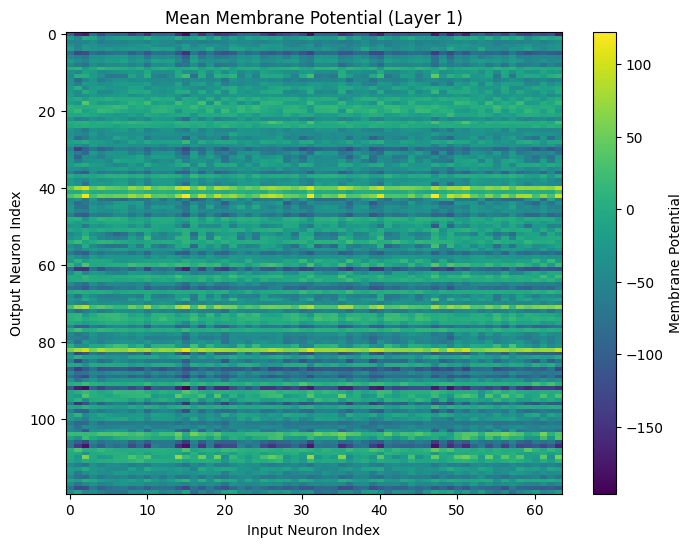

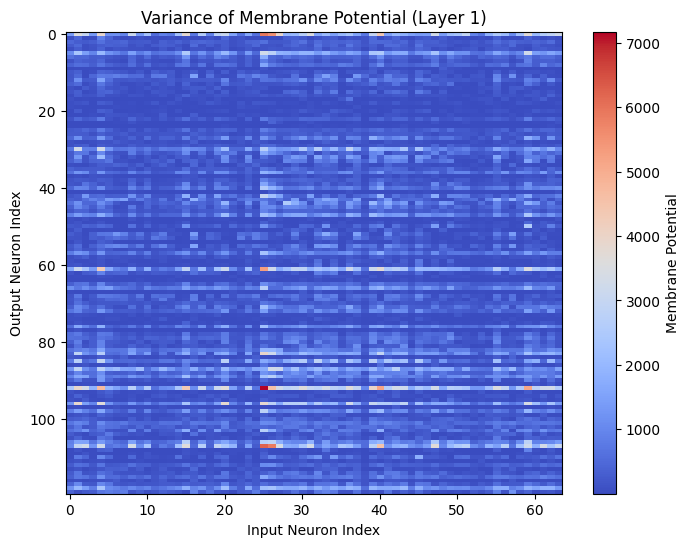

In [13]:
output = model(input)